In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# !pip install --upgrade ipykernel

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
path_to_data = r"car_price_dataset.csv" 

data = pd.read_csv(path_to_data)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [44]:
from sklearn.preprocessing import StandardScaler
print(data.dtypes)

x =  np.where(data.dtypes.to_numpy() == np.dtype('int64'))
y = np.where(data.dtypes.to_numpy() == np.dtype('float64'))

numeric_cols_idx = np.concatenate((x[0],y[0]))
print(numeric_cols_idx)
numeric_cols = data.columns[numeric_cols_idx]

print(numeric_cols)
scaler = StandardScaler()
scaler.fit(data[numeric_cols])

# print(data.columns)


Brand            object
Model            object
Year              int64
Engine_Size     float64
Fuel_Type        object
Transmission     object
Mileage           int64
Doors             int64
Owner_Count       int64
Price             int64
dtype: object
[2 6 7 8 9 3]
Index(['Year', 'Mileage', 'Doors', 'Owner_Count', 'Price', 'Engine_Size'], dtype='object')


StandardScaler()

In [45]:
data[numeric_cols] = scaler.transform(data[numeric_cols])
print(data)
np_data = data.to_numpy()

print(np_data)

           Brand     Model      Year  Engine_Size Fuel_Type    Transmission   
0            Kia       Rio  1.226021     1.043657    Diesel          Manual  \
1      Chevrolet    Malibu  0.066156    -0.870607    Hybrid       Automatic   
2       Mercedes       GLA  1.226021     1.043657    Diesel       Automatic   
3           Audi        Q5  1.660970    -0.870607  Electric          Manual   
4     Volkswagen      Golf -1.238692    -0.348535    Hybrid  Semi-Automatic   
...          ...       ...       ...          ...       ...             ...   
9995         Kia    Optima -1.093709     0.608597    Diesel  Semi-Automatic   
9996   Chevrolet    Impala -1.383676    -1.392679  Electric       Automatic   
9997         BMW  3 Series -0.223810    -0.000487    Petrol       Automatic   
9998        Ford  Explorer -1.383676    -1.392679    Hybrid       Automatic   
9999  Volkswagen    Tiguan -1.528659    -0.783595    Diesel          Manual   

       Mileage     Doors  Owner_Count     Price  
0

In [46]:
from sklearn.preprocessing import LabelEncoder

categoric_cols_idx = np.where(data.dtypes.to_numpy() == np.dtype('object'))[0]
categoric_cols = data.columns[categoric_cols_idx]
print(categoric_cols, categoric_cols_idx)
encoders = [LabelEncoder() for _ in range(len(categoric_cols))]

Index(['Brand', 'Model', 'Fuel_Type', 'Transmission'], dtype='object') [0 1 4 5]


In [47]:
for i in range(len(categoric_cols)):
    encoders[i].fit(data[categoric_cols[i]])
    data[categoric_cols[i]] = encoders[i].transform(data[categoric_cols[i]])

# data[categoric_cols] = data[categoric_cols].apply(lambda x: data[x.name].fit_transform(x))
print(data[categoric_cols])

BRAND_EMBED, MODEL_EMBED, FUEL_EMBED, TRANSMISSION_EMBED = (data[categoric_cols].apply(np.max)+1).to_numpy()
print(BRAND_EMBED, MODEL_EMBED, FUEL_EMBED, TRANSMISSION_EMBED)

      Brand  Model  Fuel_Type  Transmission
0         6     24          0             1
1         2     19          2             0
2         7     16          0             0
3         0     22          1             1
4         9     17          2             2
...     ...    ...        ...           ...
9995      6     20          0             2
9996      2     18          1             0
9997      1      0          3             0
9998      3     13          2             0
9999      9     27          0             1

[10000 rows x 4 columns]
10 30 4 3


In [54]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

INPUT_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CAT_COLS_IDX = categoric_cols_idx
EMBEDDING_SIZE = 4

EPOCHS = 100

class dataset(Dataset):
    def __init__(self, data, numeric_cols, categoric_cols):
        self.numeric_data = torch.tensor(data[numeric_cols[:-1]].to_numpy(), dtype = torch.float32)
        self.categoric_data = torch.tensor(data[categoric_cols].to_numpy())
        self.price = torch.tensor(data['Price'].to_numpy(), dtype = torch.float32)

    def __len__(self):
        return len(self.price)

    def __getitem__(self, idx):
        num_features = self.numeric_data[idx]
        cat_features = self.categoric_data[idx]
        price = self.price[idx]
        return num_features, cat_features, price

def collate_fn(batch):
    num_batch = torch.stack([item[0] for item in batch])
    cat_batch = torch.stack([item[1] for item in batch])
    prices = torch.stack([item[2] for item in batch])
    return num_batch, cat_batch, prices


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.ln1 = nn.Linear(4*4 + 5, INPUT_SIZE//2)
        self.ln2 = nn.Linear(INPUT_SIZE//2, INPUT_SIZE//4)
        self.out = nn.Linear(INPUT_SIZE//4, 1)
        self.relu = nn.ReLU()

        embed_list = [BRAND_EMBED, MODEL_EMBED, FUEL_EMBED, TRANSMISSION_EMBED]

        self.embeddings = nn.ModuleList([nn.Embedding(i, EMBEDDING_SIZE) for i in embed_list])

    def forward(self, num, cat) -> torch.Tensor:
        num = num.to(DEVICE)
        cat = cat.to(DEVICE)

        embeds = [self.embeddings[i](cat[:, i]) for i in range(len(CAT_COLS_IDX))]
        embed = torch.cat(embeds, dim=1) 

        x = torch.cat((embed, num), dim=1)
        return self.out(self.relu(self.ln2(self.relu(self.ln1(x)))))

import matplotlib.pyplot as plt
def train(net: Net, trainloader, epochs = EPOCHS):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
    losses = []
    for _ in range(epochs):
        epoch_loss = 0
        for num_batch, cat_batch, price_batch in trainloader:
            num_batch = num_batch.to(DEVICE)
            cat_batch = cat_batch.to(DEVICE)
            price_batch = price_batch.to(DEVICE)
            # print(cat_batch, cat_batch.shape)
            optimizer.zero_grad()
            y_out = net(num_batch, cat_batch).squeeze(1)
            # print(y_out.shape, price_batch.shape)
            loss = criterion(y_out, price_batch)
            loss.backward()
            optimizer.step()
            epoch_loss+= loss.item()
        epoch_loss/= len(trainloader.dataset)
        losses.append(epoch_loss)
        if(_%10==0):
            print(f"EPOCH: {_}, LOSS: {epoch_loss}")
    plt.plot(losses)
    plt.show()

def flwr_train(net: Net, trainloader, epochs = EPOCHS):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
    losses = []
    for _ in range(epochs):
        epoch_loss = 0
        for num_batch, cat_batch, price_batch in trainloader:
            num_batch = num_batch.to(DEVICE)
            cat_batch = cat_batch.to(DEVICE)
            price_batch = price_batch.to(DEVICE)
            # print(cat_batch, cat_batch.shape)
            optimizer.zero_grad()
            y_out = net(num_batch, cat_batch).squeeze(1)
            # print(y_out.shape, price_batch.shape)
            loss = criterion(y_out, price_batch)
            loss.backward()
            optimizer.step()
            epoch_loss+= loss.item()
        epoch_loss/= len(trainloader.dataset)
        losses.append(epoch_loss)
        if(_%10==0):
            print(f"EPOCH: {_}, LOSS: {epoch_loss}")

def test(net: Net, testloader):
    criterion = nn.MSELoss()
    net.train()
    tot_loss = 0
    with torch.no_grad():
        for num_batch, cat_batch, price_batch in testloader:
            num_batch = num_batch.to(DEVICE)
            cat_batch = cat_batch.to(DEVICE)
            price_batch = price_batch.to(DEVICE)
            y_out = net(num_batch, cat_batch).squeeze(1)
            loss = criterion(y_out, price_batch)
            tot_loss += loss.item()
    tot_loss/=len(testloader.dataset)
    return tot_loss

In [49]:
from sklearn.model_selection import train_test_split
BATCH_SIZE = 32

train_data, test_data = train_test_split(data, test_size = 0.1 )


# print(test_data, train_data)
# print(len(test_data), len(train_data))
full_dataset = dataset(data, numeric_cols, categoric_cols)
train_dataset = dataset(train_data, numeric_cols, categoric_cols)
test_dataset = dataset(test_data, numeric_cols, categoric_cols)

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)



In [50]:
# x = next(iter(trainloader))

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(net.parameters())
# for i in range(100):
#     num, cat, price = x[0][0],x[1][0], x[2][0]
#     out = net(num, cat).squeeze(0)
#     optimizer.zero_grad()
#     loss = criterion(out, price)
#     if(i%10==0):
#         print("out: ", out, "price: ", price, "loss: ",loss)
#     loss.backward()
#     optimizer.step()
net = Net()
net = net.to(DEVICE)
print(net)

Net(
  (ln1): Linear(in_features=21, out_features=128, bias=True)
  (ln2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (embeddings): ModuleList(
    (0): Embedding(10, 4)
    (1): Embedding(30, 4)
    (2): Embedding(4, 4)
    (3): Embedding(3, 4)
  )
)


In [51]:

num_batch, cat_batch, price_batch = next(iter(trainloader))

# print(num_batch, num_batch.shape )
# print(cat_batch, cat_batch.shape )
# print(price_batch, price_batch.shape )

# brand_embed = nn.Embedding(BRAND_EMBED, 10)
# model_embed = nn.Embedding(MODEL_EMBED, 10)
# fuel_embed = nn.Embedding(FUEL_EMBED, 10)
# transmission_embed = nn.Embedding(TRANSMISSION_EMBED, 10)

# embeddings = nn.ModuleList( [brand_embed, model_embed, fuel_embed, transmission_embed] )

# embed = torch.tensor([])

# for i in range(len(CAT_COLS_IDX)):
#     embed = torch.concat((embed, embeddings[i](cat_batch[:, i]),))
# print(embed, embed.shape)


EPOCH: 0, LOSS: 0.0008245136773782886
EPOCH: 10, LOSS: 2.4138070058042e-05
EPOCH: 20, LOSS: 7.047817816530571e-07


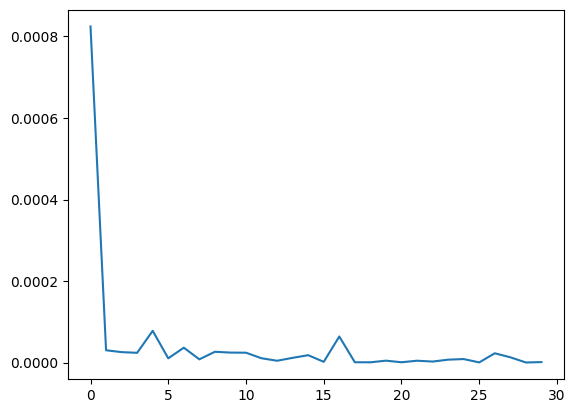

In [52]:
train(net, trainloader, epochs = 30)


In [55]:
print("TEST LOSS: ", test(net, testloader))

TEST LOSS:  6.612179245166772e-07


In [ ]:
# %%capture
# !pip install flwr[simulation]

In [ ]:
# %%capture
# pip install flwr-datasets

In [56]:
from datasets import load_dataset
from flwr_datasets.partitioner import IidPartitioner
from datasets import Dataset as HFdataset
from torch.utils.data import Subset
import sklearn
NUM_CLIENTS = 5

class Federated_Dataset():
    def __init__(self, dataset, num_client = NUM_CLIENTS):
        self.data_per_client = len(dataset) // num_client
        self.indices = np.random.permutation(len(dataset))
        self.dataset = dataset
        self.partitioned_dataset = []
        for i in range(num_client):
            self.partitioned_dataset.append(Subset(dataset, self.indices[i*self.data_per_client: (i+1)*self.data_per_client]))
    def load_partition(self, partition_id: int):
        return self.partitioned_dataset[partition_id]

def partition_dataset(dataset, num_client = NUM_CLIENTS):
    data_per_client = len(dataset) // num_client
    indices = np.random.permutation(len(dataset))
    partitioned_dataset = []
    for i in range(num_client):
        partitioned_dataset.append(Subset(dataset, indices[i*data_per_client: (i+1)*data_per_client]))
        print(partitioned_dataset[i].__len__())
    print(partitioned_dataset)
    return partitioned_dataset

def load_datasets(fds: Federated_Dataset, partition_id: int):
    partition = fds.load_partition(partition_id)
    train_partition, test_partition = sklearn.model_selection.train_test_split(partition, test_size = 0.1)
    fds_trainloader = DataLoader(train_partition, batch_size = BATCH_SIZE, shuffle = True)
    fds_testloader = DataLoader(test_partition, batch_size = BATCH_SIZE, shuffle = False)
    return fds_trainloader, fds_testloader








In [57]:
fds = Federated_Dataset(full_dataset, num_client = NUM_CLIENTS)
part_0= fds.load_partition(partition_id = 0)

part0_trainloader, part0_testloader =  load_datasets(fds, 0)
# print(next(iter(part0_trainloader)))

In [58]:
from collections import OrderedDict
def set_parameters(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net):
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [59]:
from flwr.client import NumPyClient, Client, ClientApp
from flwr.common import Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.client import NumPyClient, Client, ClientApp
from flwr.common import Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from collections import OrderedDict
import torch

class FlowerClient(NumPyClient):
    def __init__(self, partition_id, net,  trainloader, testloader):
        self.net = net
        self.trainloader = trainloader
        self.testloader = testloader
        self.partition_id = partition_id

    def set_params(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=False)

    def get_params(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def fit(self, params, config):
        print(f"[Client {self.partition_id}] ----Training----")
        self.set_params(params)
        flwr_train(self.net, self.trainloader, epochs=30)
        return self.get_params(self.net), len(self.trainloader.dataset), {}

    def evaluate(self, params, config):
        self.set_params(params)
        loss = test(self.net, self.testloader)
        print(f"[Client {self.partition_id}] evaluate, Test_loss:{loss}")
        return loss, len(self.testloader.dataset), {'loss': loss}

def client_fn(context: Context):
    net = Net().to(DEVICE)
    partition_id = context.node_config['partition-id']
    print("NODE CONFIG: ", partition_id)
    trainloader, testloader = load_datasets(fds, partition_id)
    return FlowerClient(partition_id, net, trainloader, testloader).to_client()

client = ClientApp(client_fn=client_fn)


In [60]:
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=1,  # Sample 50% of available clients for evaluation
    min_fit_clients=NUM_CLIENTS,  # Never sample less than 10 clients for training
    min_evaluate_clients=NUM_CLIENTS,  # Never sample less than 5 clients for evaluation
    min_available_clients=NUM_CLIENTS,  # Wait until all 10 clients are available
)

In [61]:
def server_fn(context:Context):
    config = ServerConfig(num_rounds = 3)
    return ServerAppComponents(strategy = strategy, config = config)

server = ServerApp(server_fn = server_fn)

In [62]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [63]:
from flwr.simulation import run_simulation

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=39332) NODE CONFIG:  0
(ClientAppActor pid=39332) NODE CONFIG:  0
(ClientAppActor pid=39332) [Client 0] ----Training----
(ClientAppActor pid=39332) EPOCH: 0, LOSS: 0.003418980764432086
(ClientAppActor pid=39332) EPOCH: 10, LOSS: 4.756047375849448e-05
(ClientAppActor pid=39332) EPOCH: 20, LOSS: 6.0174174658540225e-05
(ClientAppActor pid=39332) [Client 0] get_parameters
(ClientAppActor pid=39332) NODE CONFIG:  1
(ClientAppActor pid=39332) [Client 1] ----Training----
(ClientAppActor pid=39332) EPOCH: 0, LOSS: 0.004123312429938879
(ClientAppActor pid=39332) EPOCH: 10, LOSS: 7.259479287313297e-05
(ClientAppActor pid=39332) EPOCH: 20, LOSS: 1.8654999035384714e-05
(ClientAppActor pid=39332) [Client 1] get_parameters
(ClientAppActor pid=39332) NODE CONFIG:  2
(ClientAppActor pid=39332) [Client 2] ----Training----
(ClientAppActor pid=39332) EPOCH: 0, LOSS: 0.003728239212392105
(ClientAppActor pid=39332) EPOCH: 10, LOSS: 1.5881949738185438e-05
(ClientAppActor pid=39332) EPOCH

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=39332) [Client 4] get_parameters
(ClientAppActor pid=39332) NODE CONFIG:  0
(ClientAppActor pid=39332) [Client 0] evaluate, Test_loss:0.0358994996547699
(ClientAppActor pid=39332) NODE CONFIG:  1
(ClientAppActor pid=39332) [Client 1] evaluate, Test_loss:0.033671630322933195
(ClientAppActor pid=39332) NODE CONFIG:  2


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=39332) [Client 2] evaluate, Test_loss:0.04191063642501831
(ClientAppActor pid=39332) NODE CONFIG:  3
(ClientAppActor pid=39332) [Client 3] evaluate, Test_loss:0.03552295833826065
(ClientAppActor pid=39332) NODE CONFIG:  4
(ClientAppActor pid=39332) [Client 4] evaluate, Test_loss:0.03279201030731201
(ClientAppActor pid=39332) NODE CONFIG:  0
(ClientAppActor pid=39332) [Client 0] ----Training----
(ClientAppActor pid=39332) EPOCH: 0, LOSS: 0.00549904580357381
(ClientAppActor pid=39332) EPOCH: 10, LOSS: 2.335916485410255e-06
(ClientAppActor pid=39332) EPOCH: 20, LOSS: 1.7183604884646937e-06
(ClientAppActor pid=39332) [Client 0] get_parameters
(ClientAppActor pid=39332) NODE CONFIG:  1
(ClientAppActor pid=39332) [Client 1] ----Training----
(ClientAppActor pid=39332) EPOCH: 0, LOSS: 0.005145195355224941
(ClientAppActor pid=39332) EPOCH: 10, LOSS: 4.208787781357791e-06
(ClientAppActor pid=39332) EPOCH: 20, LOSS: 8.271360412537535e-06
(ClientAppActor pid=39332) [Client 1] g

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=39332) [Client 4] get_parameters
(ClientAppActor pid=39332) NODE CONFIG:  0
(ClientAppActor pid=39332) [Client 0] evaluate, Test_loss:0.001626476850360632
(ClientAppActor pid=39332) NODE CONFIG:  1
(ClientAppActor pid=39332) [Client 1] evaluate, Test_loss:0.0014555238373577595
(ClientAppActor pid=39332) NODE CONFIG:  2
(ClientAppActor pid=39332) [Client 2] evaluate, Test_loss:0.0013296476472169161
(ClientAppActor pid=39332) NODE CONFIG:  3


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=39332) [Client 3] evaluate, Test_loss:0.001582944793626666
(ClientAppActor pid=39332) NODE CONFIG:  4
(ClientAppActor pid=39332) [Client 4] evaluate, Test_loss:0.0020503917708992957
(ClientAppActor pid=39332) NODE CONFIG:  0
(ClientAppActor pid=39332) [Client 0] ----Training----
(ClientAppActor pid=39332) EPOCH: 0, LOSS: 0.0001525010173564725
(ClientAppActor pid=39332) EPOCH: 10, LOSS: 1.1921249324586825e-06
(ClientAppActor pid=39332) EPOCH: 20, LOSS: 7.091119749626766e-05
(ClientAppActor pid=39332) [Client 0] get_parameters
(ClientAppActor pid=39332) NODE CONFIG:  1
(ClientAppActor pid=39332) [Client 1] ----Training----
(ClientAppActor pid=39332) EPOCH: 0, LOSS: 0.0001494160236486803
(ClientAppActor pid=39332) EPOCH: 10, LOSS: 6.035627310059984e-07
(ClientAppActor pid=39332) EPOCH: 20, LOSS: 4.626691657500083e-06
(ClientAppActor pid=39332) [Client 1] get_parameters
(ClientAppActor pid=39332) NODE CONFIG:  2
(ClientAppActor pid=39332) [Client 2] ----Training----
(Cl

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=39332) [Client 4] get_parameters
(ClientAppActor pid=39332) NODE CONFIG:  0
(ClientAppActor pid=39332) [Client 0] evaluate, Test_loss:7.290155372174923e-07
(ClientAppActor pid=39332) NODE CONFIG:  1
(ClientAppActor pid=39332) [Client 1] evaluate, Test_loss:8.391459232370834e-07
(ClientAppActor pid=39332) NODE CONFIG:  2
(ClientAppActor pid=39332) [Client 2] evaluate, Test_loss:9.493116112935241e-07
(ClientAppActor pid=39332) NODE CONFIG:  3
(ClientAppActor pid=39332) [Client 3] evaluate, Test_loss:8.667154270369792e-07
(ClientAppActor pid=39332) NODE CONFIG:  4


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 1709.13s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.03595934700965881
INFO :      		round 2: 0.0016089969798922538
INFO :      		round 3: 8.375462202820927e-07
INFO :      


(ClientAppActor pid=39332) [Client 4] evaluate, Test_loss:8.035426026253845e-07
